In [72]:
# Import necessary packages.

import networkx as nx
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from keras.models import Model
import random
import time
from itertools import combinations
from pulp import LpBinary, LpMaximize, LpMinimize, LpProblem, LpVariable, lpSum

In [73]:
# Graph helper functions.
def neighborhood(G, v):
    return list(nx.neighbors(G, v))

def set_neighborhood(G, nodes):
    N = set()
    for n in nodes:
        N |= set(neighborhood(G, n))
    return list(N)

def closed_neighborhood(G, v):
    return list(set(neighborhood(G, v)).union([v]))

In [74]:
# Set up a linear-integer optimization formulation to compute exactly a largest
# independent set in a graph.
def max_independent_set_ilp(G):
    prob = LpProblem("max-independent-set", LpMaximize)
    variables = {
        node: LpVariable("x{}".format(i + 1), 0, 1, LpBinary)
        for i, node in enumerate(G.nodes())
    }
    prob += lpSum(variables)
    for e in G.edges():
        prob += variables[e[0]] + variables[e[1]] <= 1
    prob.solve()
    solution_set = {node for node in variables if variables[node].value() == 1}
    return solution_set

# Compute the independence number of a graph exactly.
def independence_number(G):
    return len(max_independent_set_ilp(G))

In [75]:
# Function to convert adjacency matrix and heatmap to fixed-size image.
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

# Function to generate random graphs and calculate their independence number.
def generate_independence_number_data(num_graphs, max_nodes):
    graphs = []
    independence_numbers = []
    for _ in range(num_graphs):
        num_nodes = random.randint(5, max_nodes)
        G = nx.gnp_random_graph(num_nodes, np.random.rand())
        ind_num = independence_number(G)
        graphs.append(G)
        independence_numbers.append(ind_num)
    return graphs, independence_numbers

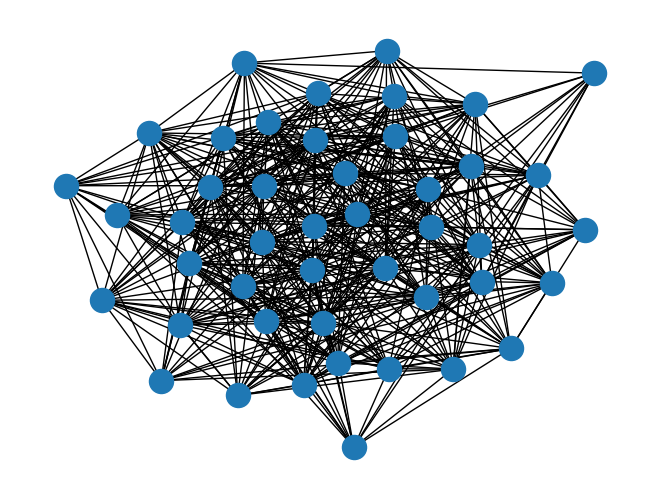

In [76]:
G = nx.gnp_random_graph(45, 0.5)
nx.draw(G)
plt.show()

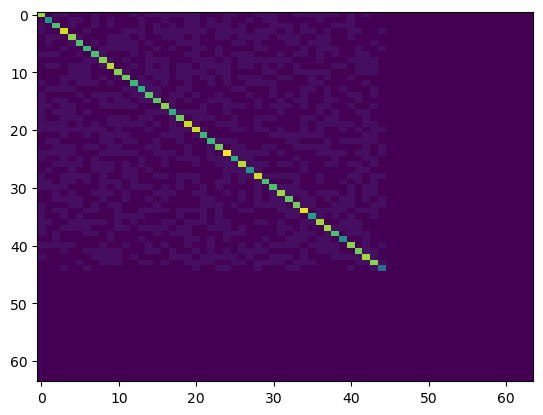

In [77]:
image = convert_to_heatmap_image(G)
plt.imshow(image, cmap='viridis', aspect='auto')
plt.show()

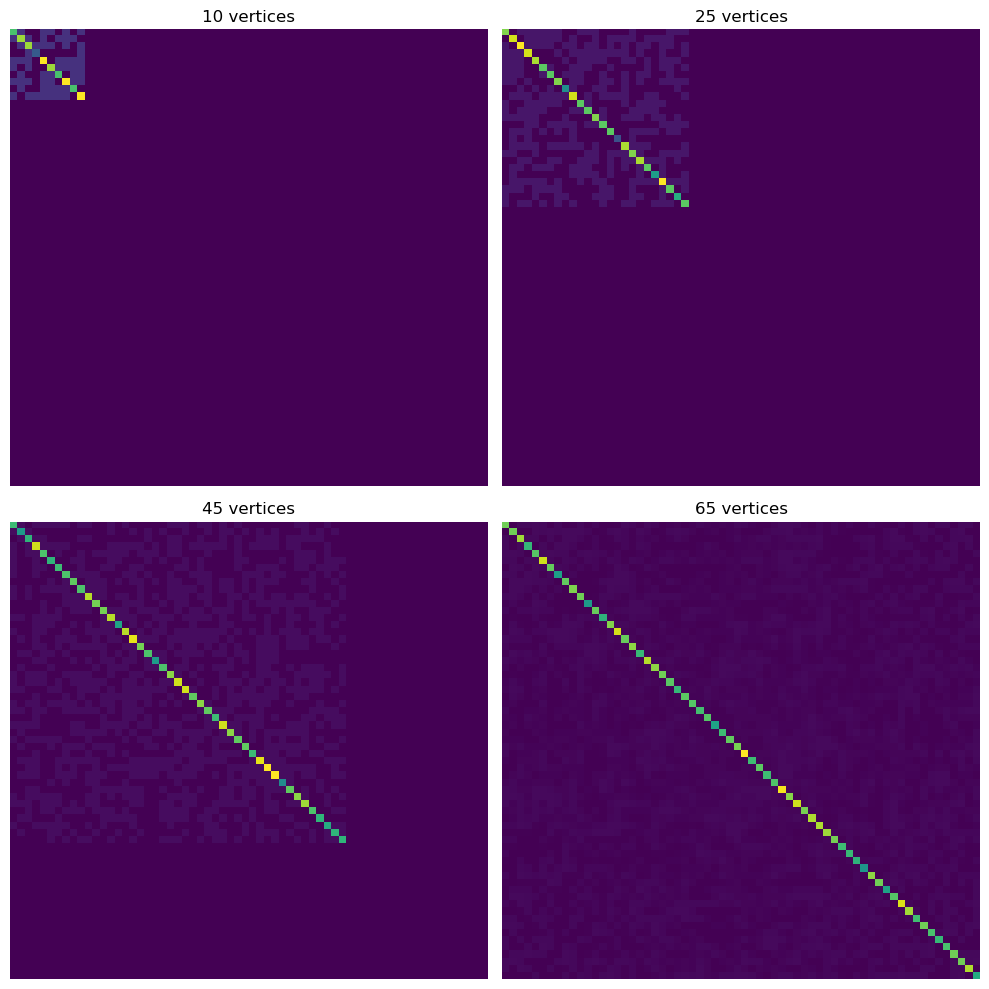

In [78]:
# Create graphs with different numbers of vertices
graphs = [
    nx.gnp_random_graph(10, 0.5),
    nx.gnp_random_graph(25, 0.5),
    nx.gnp_random_graph(45, 0.5),
    nx.gnp_random_graph(65, 0.5)
]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for the subplots
titles = ['10 vertices', '25 vertices', '45 vertices', '65 vertices']

for i, (G, ax) in enumerate(zip(graphs, axs.flatten())):
    image = convert_to_heatmap_image(G)
    ax.imshow(image, cmap='viridis', aspect='auto')
    ax.set_title(titles[i])
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

In [79]:
# Generate dataset of 2,000 random graphs with varying node sizes 10 <= n <= 64.
num_graphs = 100
max_nodes = 64
graphs, independence_numbers = generate_independence_number_data(num_graphs, max_nodes)

# Convert graphs to images.
target_size = 64
images = [convert_to_heatmap_image(graph, target_size) for graph in graphs]
X = np.array([np.array(image).reshape(target_size, target_size, 1) for image in images])
y = np.array(independence_numbers)

# Split dataset into training and testing.
split_index = int(0.8 * num_graphs)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/2172e99f2cda4252a28218aa4f802836-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/2172e99f2cda4252a28218aa4f802836-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1375 COLUMNS
At line 4290 RHS
At line 5661 BOUNDS
At line 5720 ENDATA
Problem MODEL has 1370 rows, 58 columns and 2740 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 29 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1368 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1308 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1290 strengthened rows, 0 substitutions
Cgl0003I 0 fixed

/var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/ipykernel_10574/621052219.py:24: RuntimeWarning: invalid value encountered in divide
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)
/var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/ipykernel_10574/621052219.py:24: RuntimeWarning: invalid value encountered in cast
  combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)


In [80]:
# Define the CNN model.
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

# Instantiate and train the model.
input_shape = (target_size, target_size, 1)
model = create_model(input_shape)
model.summary()
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 645,697 (2.46 MB)

 Trainable params: 645,697 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 481.2241 - mae: 13.5002 - val_loss: 55.0669 - val_mae: 5.2666
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 75.9852 - mae: 6.9435 - val_loss: 111.6201 - val_mae: 7.7127
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 66.0059 - mae: 6.5624 - val_loss: 107.8856 - val_mae: 7.6346
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 61.7219 - mae: 6.2051 - val_loss: 92.3203 - val_mae: 6.8331
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 42.9555 - mae: 4.6210 - val_loss: 72.8007 - val_mae: 5.7859
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 35.9188 - mae: 4.0631 - val_loss: 46.7750 - val_mae: 4.5041
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 26.4804 - mae: 4.1023 - val_loss: 36.3160 - val_mae: 4.1313
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 23.6337 - mae: 3.9950 - val_loss: 40.0283 - val_mae: 4.0823
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 18

In [81]:
# Evaluate the model.
loss, mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {mae}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 106.9846 - mae: 5.0174
Test MAE: 5.017374515533447


In [82]:
# Generate a random graph with n nodes.
n = 30
G = nx.gnp_random_graph(n, np.random.rand())

# Convert adjacency matrix to image with heatmap.
adj_image = convert_to_heatmap_image(G)

# Prepare the image for the model.
input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension.

# Predict the independence number using the trained CNN.
predicted_independence_number = model.predict(input_image)
print(f"Predicted independence number for the {n}-node graph: {predicted_independence_number[0][0]}")

# Compute the actual independence number using linear-integer programming for comparison.
actual_independence_number = independence_number(G)
print(f"Computed independence number for the {n}-node graph: {actual_independence_number}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted independence number for the 30-node graph: 2.472425937652588
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/6ce6776d984d464a8b068be8a2a891f8-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/6ce6776d984d464a8b068be8a2a891f8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 402 COLUMNS
At line 1287 RHS
At line 1685 BOUNDS
At line 1716 ENDATA
Problem MODEL has 397 rows, 30 columns and 794 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 397 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 359 strengthened rows, 0 subs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/33c0df9c61704fd69922dcfb52506efc-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/33c0df9c61704fd69922dcfb52506efc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 200 COLUMNS
At line 681 RHS
At line 877 BOUNDS
At line 908 ENDATA
Problem MODEL has 195 rows, 30 columns and 390 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 15 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 170 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 117 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 65 strengthened rows, 0 su

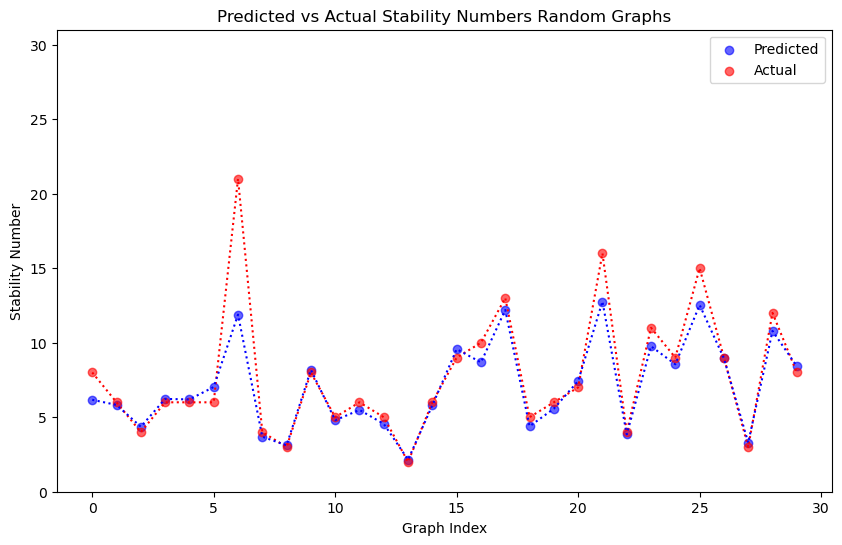

In [83]:
import pandas as pd
# Generate and process multiple random graphs
num_graphs = 30
num_nodes = 30
results = []

for _ in range(num_graphs):
    G = nx.gnp_random_graph(n, np.random.rand())

    # Convert adjacency matrix to image with heatmap
    adj_image = convert_to_heatmap_image(G)

    # Prepare the image for the model
    input_image = np.array(adj_image).reshape(1, 64, 64, 1)  # Add batch dimension and channel dimension

    # Predict the independence number using the trained CNN
    predicted_independence_number = model.predict(input_image)[0][0]

    # Compute the actual independence number
    actual_independence_number = independence_number(G)

    # Store the results
    results.append({
        "Graph Index": _,
        "Predicted Independence Number": predicted_independence_number,
        "Actual Independence Number": actual_independence_number
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Display the results as a table
print(results_df)

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(results_df["Graph Index"], results_df["Predicted Independence Number"], label="Predicted", color='blue', alpha=0.6)
plt.scatter(results_df["Graph Index"], results_df["Actual Independence Number"], label="Actual", color='red', alpha=0.6)
plt.plot(results_df["Graph Index"], results_df["Actual Independence Number"], color='red', linestyle='dotted')
plt.plot(results_df["Graph Index"], results_df["Predicted Independence Number"], color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers Random Graphs")
plt.ylim(0, num_nodes+1)
plt.legend()


# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Test MSE: 106.9846499280618
Test MAE: 5.017374064028263
Test RMSE: 10.343338432443453
Test R-squared: -0.17788827419281006
95% Confidence Interval for the Predictions: (4.736016956049747, 8.87554291180914)


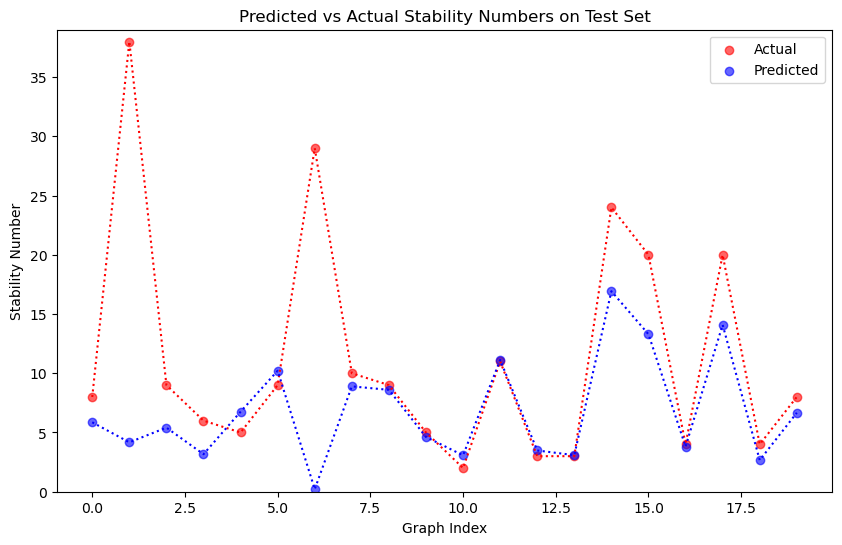

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model on the test set
y_pred = model.predict(X_test).flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_val = rmse(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse_val}')
print(f'Test R-squared: {r2}')

# Calculate 95% confidence intervals for the predictions
conf_interval = stats.t.interval(0.95, len(y_test) - 1, loc=np.mean(y_pred), scale=stats.sem(y_pred))
print(f'95% Confidence Interval for the Predictions: {conf_interval}')

# Display results in a DataFrame
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Plot the results as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color='red', alpha=0.6)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color='blue', alpha=0.6)
plt.plot(range(len(y_test)), y_test, color='red', linestyle='dotted')
plt.plot(range(len(y_test)), y_pred, color='blue', linestyle='dotted')
plt.xlabel("Graph Index")
plt.ylabel("Stability Number")
plt.title("Predicted vs Actual Stability Numbers on Test Set")
plt.ylim(0, max(y_test) + 1)
plt.legend()


# Optionally, save the figure
plt.savefig("stability_number_prediction_comparison_test_set.png")
plt.show()


In [85]:
# Ablation Study
# Model without max pooling layers
def create_model_no_pooling(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression

    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

model_no_pooling = create_model_no_pooling(input_shape)
model_no_pooling.fit(X_train, y_train, epochs=15, validation_split=0.2)
loss_no_pooling, mae_no_pooling = model_no_pooling.evaluate(X_test, y_test)
print(f'Model without Pooling Layers - Test MAE: {mae_no_pooling}')


Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - loss: 22578.9141 - mae: 77.5418 - val_loss: 852.3936 - val_mae: 22.8293
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 984.3530 - mae: 23.8056 - val_loss: 69.9420 - val_mae: 6.2998
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 25.4381 - mae: 3.9666 - val_loss: 38.1312 - val_mae: 4.4339
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 27.4069 - mae: 4.0830 - val_loss: 38.7033 - val_mae: 4.4218
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 20.4744 - mae: 3.5131 - val_loss: 43.1144 - val_mae: 4.6389
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 17.6955 - mae: 3.1346 - val_loss: 47.8388 - val_mae: 4.9078
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 17.4215 - mae: 3.0389 - val_loss: 44.1930 - val_mae: 4.6432
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 16.9868 - mae: 3.1657 - val_loss: 35.6476 - val_mae: 4.1740
Epoch 9/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/ste

In [86]:
# Stability / Domination / Total Domination’dan bağımsız bir hücredir.
# Sadece modelin mimarisini tanımlar (kaç katman, aktivasyon ne, çıkış sayısı kaç vs.)
from tensorflow.keras import Input, Model

inputs = Input(shape=(64, 64, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [87]:
#Stability / Domination / Total Domination’dan bağımsız bir hücredir.
print(model.input)   # ➜ <KerasTensor: shape=(None, 64, 64, 1) ...>
print(model.output)  # ➜ <KerasTensor: shape=(None, 1) ...>


<KerasTensor shape=(None, 64, 64, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_263>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_271>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


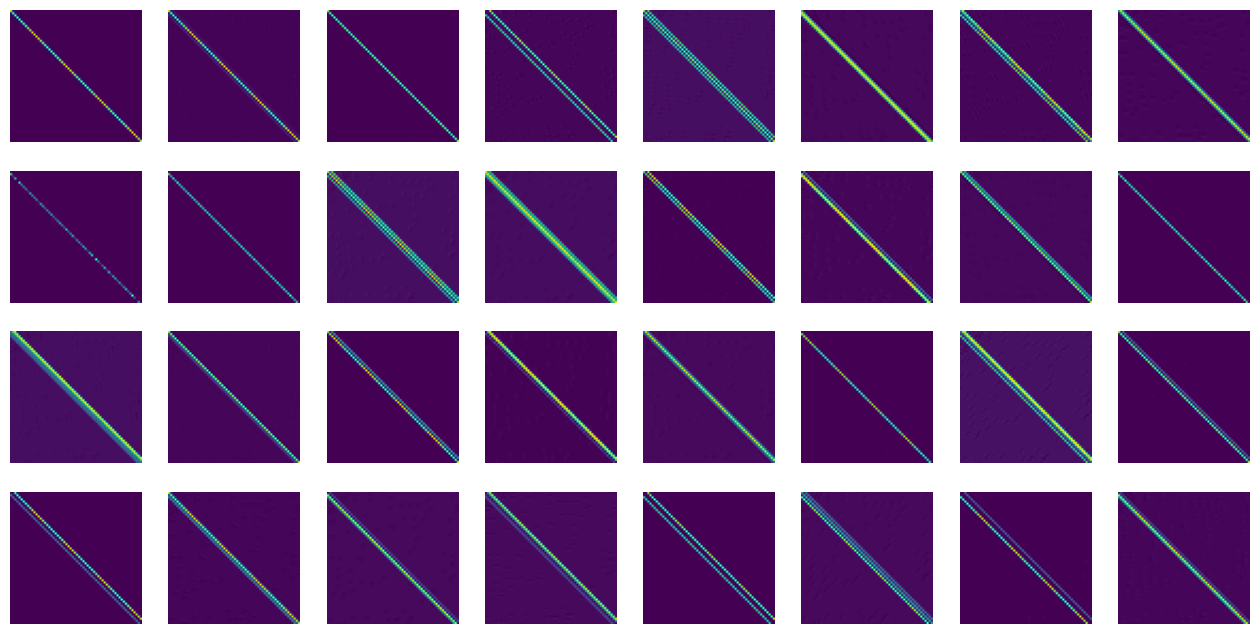

In [88]:
# Stability / Domination / Total Domination’dan bağımsız bir hücredir.
#Ne yapar bu hücre?
#Bir random graph oluşturur
#Onu CNN’e input olarak verir
#Ardından modelin ara katmanlarındaki (özellikle conv katmanları) aktivasyonları (feature maps) çıkarır
#Bu feature map’leri görselleştirir
#Tahmin edilen değerle (hangi metrik olduğu) hiç ilgilenmez. Sadece girişe verilen grafın CNN içinde nasıl işlendiğini gösterir.

# Choose a random graph and convert it to an image
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Create a model to output the intermediate layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps for the input image
activations = activation_model.predict(input_image)

# Visualize the feature maps for a specific layer (e.g., first convolutional layer)
layer_activation = activations[0]
n_features = layer_activation.shape[-1]
size = layer_activation.shape[1]

# Plot each feature map in a grid
n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.imshow(layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

# plt.title('Feature Maps of First Convolutional Layer')
plt.show()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/f333d842ce7a47349e307030d1e9103e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/f333d842ce7a47349e307030d1e9103e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1207 COLUMNS
At line 3804 RHS
At line 5007 BOUNDS
At line 5072 ENDATA
Problem MODEL has 1202 rows, 64 columns and 2404 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1202 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1105 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1080 strengthened rows, 0 substitutions
Cgl0003I 0 fixed

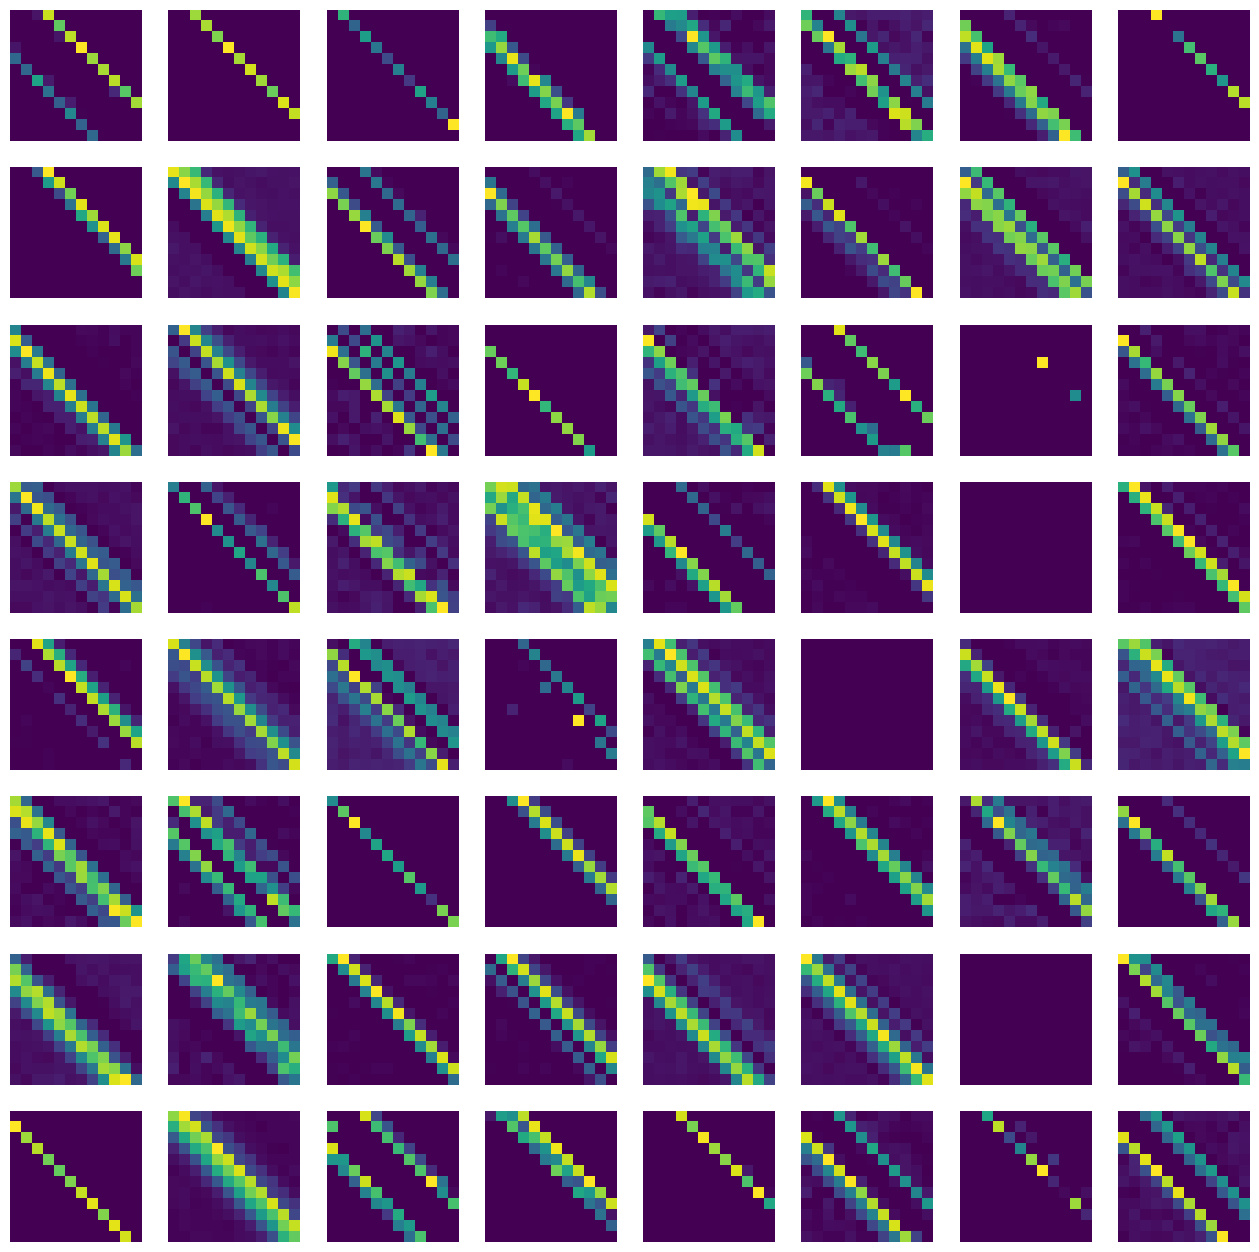

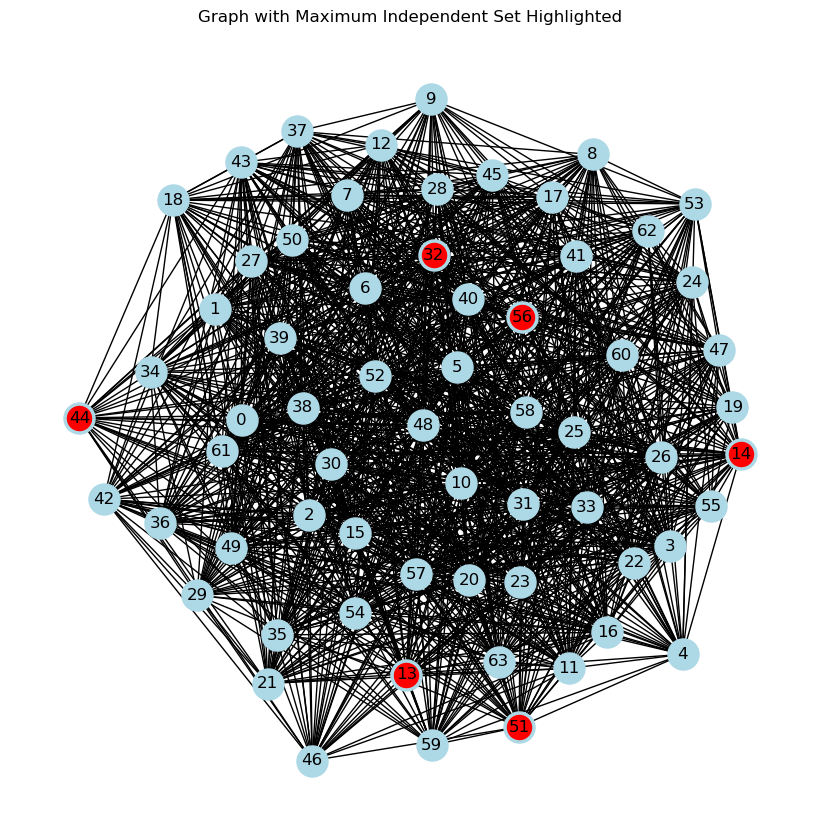

In [89]:

#  Function to convert adjacency matrix and heatmap to fixed-size image
def convert_to_heatmap_image(G, target_size=64):
    adj_matrix = nx.to_numpy_array(G)
    matrix_size = adj_matrix.shape[0]

    if matrix_size < target_size:
        padded_matrix = np.zeros((target_size, target_size), dtype=int)
        padded_matrix[:matrix_size, :matrix_size] = adj_matrix
    elif matrix_size > target_size:
        image = Image.fromarray(adj_matrix)
        padded_matrix = np.array(image.resize((target_size, target_size), Image.BILINEAR))
    else:
        padded_matrix = adj_matrix

    degree_dict = dict(G.degree())
    degrees = np.array([degree_dict[node] for node in G.nodes()])
    heatmap = np.zeros((target_size, target_size), dtype=float)

    for i, node in enumerate(G.nodes()):
        if i < target_size:
            heatmap[i, i] = degrees[i]

    combined_matrix = padded_matrix + heatmap
    combined_image = (combined_matrix / combined_matrix.max() * 255).astype(np.uint8)

    return Image.fromarray(combined_image, 'L')

# Generate a random graph and convert it to an image
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Compute the maximum independent set
mis = max_independent_set_ilp(G)
print(f"Maximum Independent Set: {mis}")

# Extract feature maps from the last convolutional layer
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(input_image)
last_layer_activation = activations[-1]

# Visualize the feature maps for the last convolutional layer
n_features = last_layer_activation.shape[-1]
size = last_layer_activation.shape[1]

# Plot each feature map in a grid
n_cols = 8
n_rows = n_features // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i in range(n_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.imshow(last_layer_activation[0, :, :, i], cmap='viridis')
    ax.axis('off')

# plt.suptitle('Feature Maps of Last Convolutional Layer')
plt.show()

# Visualize the graph and highlight the maximum independent set
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=mis, node_color='red')
plt.title('Graph with Maximum Independent Set Highlighted')
plt.show()


In [90]:
import time

# Generate a random graph
num_nodes = 64
G = nx.gnp_random_graph(num_nodes, np.random.rand())

# Measure time for ILP method
start_time = time.time()
mis = max_independent_set_ilp(G)
ilp_time = time.time() - start_time
ilp_independence_number = len(mis)

# Convert graph to image
input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

# Measure time for CNN prediction
start_time = time.time()
cnn_pred = model.predict(input_image)[0][0]
cnn_time = time.time() - start_time

print(f"ILP Method: Independence Number = {ilp_independence_number}, Time Taken = {ilp_time:.4f} seconds")
print(f"CNN Method: Predicted Independence Number = {cnn_pred:.4f}, Time Taken = {cnn_time:.4f} seconds")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/80fdbdff992c4fdd96198ad26a5a7bce-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/80fdbdff992c4fdd96198ad26a5a7bce-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1809 COLUMNS
At line 5610 RHS
At line 7415 BOUNDS
At line 7480 ENDATA
Problem MODEL has 1804 rows, 64 columns and 3608 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 1804 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1738 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1714 strengthened rows, 0 substitutions
Cgl0003I 0 fixed

In [91]:
# Parameters
num_trials = 10
num_nodes = 64

ilp_times = []
cnn_times = []
ilp_results = []
cnn_results = []

for _ in range(num_trials):
    # Generate a random graph
    G = nx.gnp_random_graph(num_nodes, np.random.rand())

    # Measure time for ILP method
    start_time = time.time()
    mis = max_independent_set_ilp(G)
    ilp_time = time.time() - start_time
    ilp_independence_number = len(mis)

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    ilp_times.append(ilp_time)
    cnn_times.append(cnn_time)
    ilp_results.append(ilp_independence_number)
    cnn_results.append(cnn_pred)

# Compute averages
avg_ilp_time = np.mean(ilp_times)
avg_cnn_time = np.mean(cnn_times)
avg_ilp_result = np.mean(ilp_results)
avg_cnn_result = np.mean(cnn_results)

print(f"Average ILP Time: {avg_ilp_time:.4f} seconds")
print(f"Average CNN Time: {avg_cnn_time:.4f} seconds")
print(f"Average ILP Stability Number: {avg_ilp_result:.4f}")
print(f"Average CNN Predicted Stability Number: {avg_cnn_result:.4f}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/f13845acb97a455ebee77ecedd3bdf5e-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/f13845acb97a455ebee77ecedd3bdf5e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 697 COLUMNS
At line 2274 RHS
At line 2967 BOUNDS
At line 3032 ENDATA
Problem MODEL has 692 rows, 64 columns and 1384 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 645 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 451 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 198 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 t

In [92]:
# Parameters, This is the same as the previous experiment, but now repeated for 20 graphs instead of 10. It compares
#time and accuracy more thoroughly.
num_trials = 20
num_nodes = 64

ilp_times = []
cnn_times = []
ilp_results = []
cnn_results = []

for _ in range(num_trials):
    # Generate a random graph
    G = nx.gnp_random_graph(num_nodes, np.random.rand())

    # Measure time for ILP method
    start_time = time.time()
    mis = max_independent_set_ilp(G)
    ilp_time = time.time() - start_time
    ilp_independence_number = len(mis)

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    ilp_times.append(ilp_time)
    cnn_times.append(cnn_time)
    ilp_results.append(ilp_independence_number)
    cnn_results.append(cnn_pred)

# Compute averages
avg_ilp_time = np.mean(ilp_times)
avg_cnn_time = np.mean(cnn_times)
avg_ilp_result = np.mean(ilp_results)
avg_cnn_result = np.mean(cnn_results)

print(f"Average ILP Time: {avg_ilp_time:.4f} seconds")
print(f"Average CNN Time: {avg_cnn_time:.4f} seconds")
print(f"Average ILP Stability Number: {avg_ilp_result:.4f}")
print(f"Average CNN Predicted Stability Number: {avg_cnn_result:.4f}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/003c06af11ce4d3dbfff9641e43f8c27-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/003c06af11ce4d3dbfff9641e43f8c27-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 557 COLUMNS
At line 1854 RHS
At line 2407 BOUNDS
At line 2472 ENDATA
Problem MODEL has 552 rows, 64 columns and 1104 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 435 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 324 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 131 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 t

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/27804d2cecb94c9cabf79bbae38bd54f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/6c/m8gy3bzs5nv3gdd7vqsvb9940000gn/T/27804d2cecb94c9cabf79bbae38bd54f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 30 RHS
At line 34 BOUNDS
At line 40 ENDATA
Problem MODEL has 3 rows, 5 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 3 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from -3 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were activ

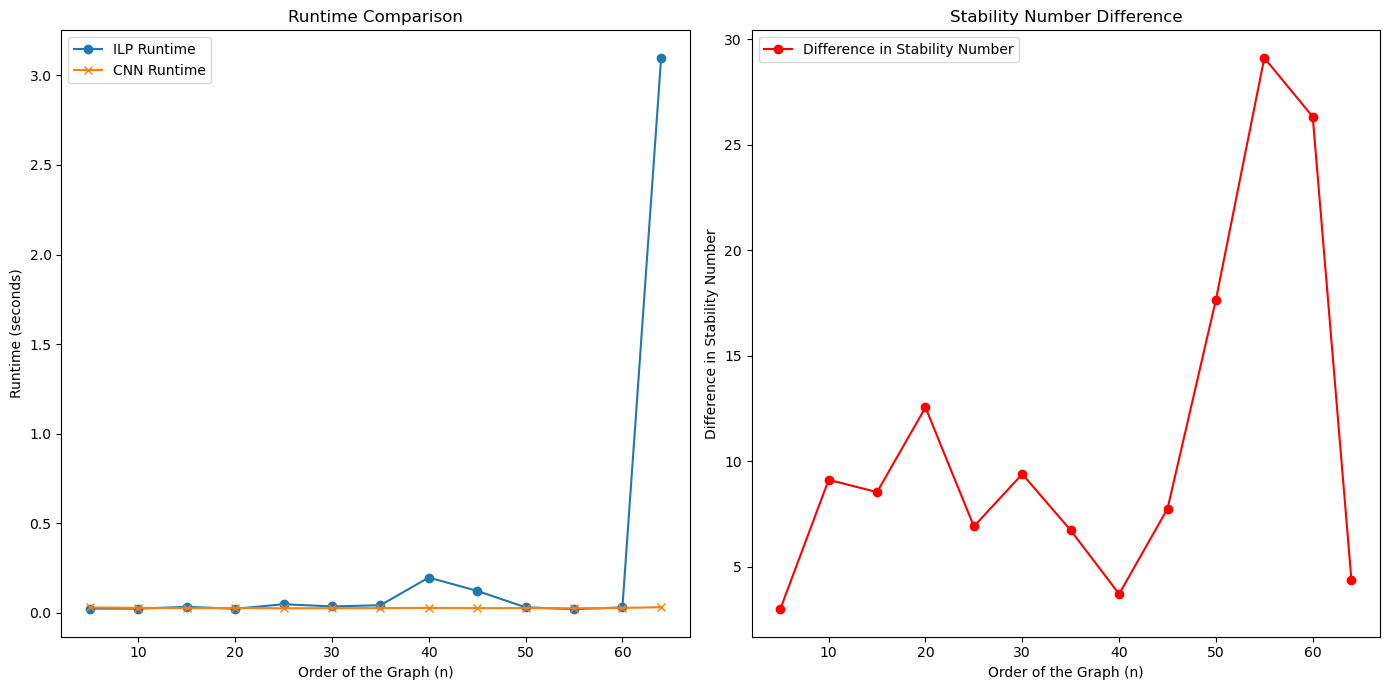

In [93]:
# Parameters
graph_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
ilp_times = []
cnn_times = []
independence_number_diffs = []

for n in graph_sizes:
    G = nx.gnp_random_graph(n, np.random.rand())

    # Measure time for ILP method
    start_time = time.time()
    mis = max_independent_set_ilp(G)
    ilp_time = time.time() - start_time
    ilp_independence_number = len(mis)

    # Convert graph to image
    input_image = np.array(convert_to_heatmap_image(G)).reshape(1, 64, 64, 1)  # Add batch and channel dimensions

    # Measure time for CNN prediction
    start_time = time.time()
    cnn_pred = model.predict(input_image)[0][0]
    cnn_time = time.time() - start_time

    # Collect results
    ilp_times.append(ilp_time)
    cnn_times.append(cnn_time)
    independence_number_diffs.append(abs(ilp_independence_number - cnn_pred))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot runtime comparison
ax1.plot(graph_sizes, ilp_times, label='ILP Runtime', marker='o')
ax1.plot(graph_sizes, cnn_times, label='CNN Runtime', marker='x')
ax1.set_xlabel('Order of the Graph (n)')
ax1.set_ylabel('Runtime (seconds)')
ax1.set_title('Runtime Comparison')
ax1.legend()

# Plot difference in independence numbers
ax2.plot(graph_sizes, independence_number_diffs, label='Difference in Stability Number', marker='o', color='r')
ax2.set_xlabel('Order of the Graph (n)')
ax2.set_ylabel('Difference in Stability Number')
ax2.set_title('Stability Number Difference')
ax2.legend()

plt.tight_layout()
plt.show()